# Photutils tutorial


## Morphological properties
Source: https://photutils.readthedocs.io/en/stable/morphology.html

## Elliptical Isophote Analysis
Source: https://photutils.readthedocs.io/en/stable/isophote.html

In [1]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_noise_image
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils import EllipticalAperture, data_properties
from astropy.io import fits

In [2]:
#data = g(x, y) + noise
hdu=fits.open('/Users/lasilla/data/2020-02-10/reduced/NGC2997/NGC2997_B.fits')
data = hdu['PRIMARY'].data

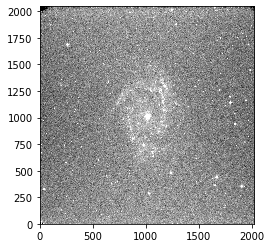

In [4]:
# how does it look?
plt.imshow(data, cmap='gray', origin='lower', vmin=9, vmax=11)

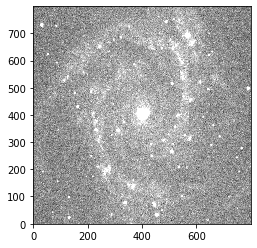

In [6]:
#cut
from astropy.nddata import Cutout2D
position = (1010, 1003)
size=(800,800)
cutout=Cutout2D (data,position,size)
plt.imshow(cutout.data,cmap='gray', origin='lower', vmin=9, vmax=11)

We first need to estimate an initial guess of the ellipse geometry and pass it to the fitters.

In [7]:
data_properties?

In [8]:
# image statistics 
mean, median, std = sigma_clipped_stats(cutout.data, sigma=3.0)
# subract background
data_sub = cutout.data - median
# first guess
cat = data_properties(data_sub)
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
tbl = cat.to_table(columns=columns)
# initialize an ellipse with the properties that we guessed
geometry = EllipseGeometry(x0=tbl['xcentroid'][0].value,
                           y0=tbl['ycentroid'][0].value,
                           pa=tbl['orientation'][0].value,
                           sma=tbl['semimajor_axis_sigma'][0].value,
                           eps=tbl['semiminor_axis_sigma'][0].value/tbl['semimajor_axis_sigma'][0].value
                           )

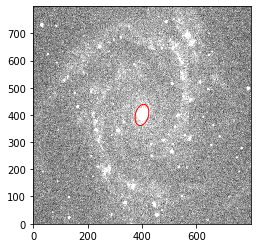

In [14]:
# how does it look?
geometry = EllipseGeometry (x0=400, y0=400, sma=40, eps=0.6,pa=75*np.pi/180)

plt.imshow(cutout.data, cmap='gray', origin='lower', vmin=9, vmax=11)
geometry.sma
aper = EllipticalAperture(positions=(geometry.x0, geometry.y0), 
                          a=geometry.sma,
                          b=geometry.sma*(geometry.eps),
                          theta=geometry.pa)
aper.plot(color='r')

Now we want to initiliaze an instance of the Ellipse class with the data and our initial guess and fit the data:

In [15]:
ellipse = Ellipse(data_sub, geometry)
isolist = ellipse.fit_image()

In [16]:
# save the output as a table
tab = isolist.to_table()
tab

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_err,grad_rerr,x0,x0_err,y0,y0_err,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,int64,int64,int64,int64
0.0,10.391543665981006,0.0,0.0,0.0,0.0,0.0,0.0,None,None,404.1294780224136,0.0,406.22871882483713,0.0,1,0,0,0
0.5487684808459423,10.190456222405771,0.006655107010172907,0.19860484513972318,0.015953886049779927,65.03738626524816,2.7277143580434755,-0.6567081431105766,0.18943333007154278,0.2884589327220296,404.1294780224136,0.004814964382508229,406.22871882483713,0.005336542958753569,13,0,10,0
0.6036453289305366,10.169325360515328,0.007358823200707945,0.2233561837322453,0.016203722105597496,61.98735090254127,2.499071154875308,-0.6290821982218122,0.1914435153406579,0.30432194056960993,404.145199547614,0.005464884829470966,406.25490987955163,0.006087495747031532,13,0,10,0
0.6640098618235902,10.148725619238308,0.007259897815033216,0.2483162221537588,0.015509277427683415,60.917771999660545,2.1822477010490515,-0.5709621863741758,0.1844493129689482,0.3230499626258449,404.1704977926468,0.005853384859902086,406.2910117632414,0.0065672534129815625,13,0,10,0
0.7304108480059492,10.131423523950534,0.007182686931170722,0.27887852801296487,0.012580887569220817,60.160912462504804,1.6046577024926052,-0.6075717738666795,0.16881200237460176,0.277847012708073,404.2025241016552,0.0053035638903686224,406.3346436312499,0.00605109740023736,13,0,10,0
0.8034519328065441,10.097752300491234,0.008025580746014104,0.28470932181029657,0.012590849852516557,55.18590489331272,1.577699623948719,-0.6116407376731412,0.18543804920048634,0.30318132488353616,404.23851145579914,0.005993864283170003,406.3680318736925,0.006577723354871375,13,0,10,0
0.8837971260871986,10.064282605692584,0.011383530584825993,0.3009475856691613,0.014856985270306135,49.93534378972383,1.7775576514295095,-0.6532266483480897,0.21381008845388233,0.32731378763339697,404.2753932806395,0.008086318461923142,406.3918929258904,0.008496734353822012,13,0,10,0
0.9721768386959185,10.0004100538432,0.012125486528291802,0.2870130773584236,0.013333616492782694,44.43486902195899,1.658904242127421,-0.7189723286068678,0.19126163661887943,0.2660208592303986,404.2988047313413,0.008083802061088344,406.4060834527708,0.00804138190781844,13,0,10,0


Text(0, 0.5, 'Ellipticity')

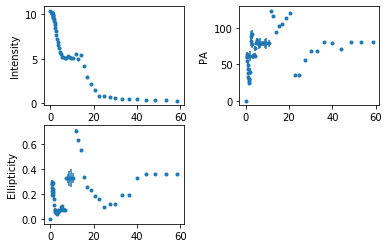

In [17]:
# have a look at some of the fitted parameters:
fig = plt.figure()
ax1 = fig.add_subplot(221)
fig.subplots_adjust(wspace=0.4)
ax1.errorbar(tab['sma'], tab['intens'],
             yerr=tab['intens_err'],
             fmt='.')
ax1.set_ylabel('Intensity')
ax2 = fig.add_subplot(222, sharex=ax1)
ax2.errorbar(tab['sma'], tab['pa'].value,
             yerr=tab['pa_err'].value,
             fmt='.')
ax2.set_ylabel('PA')
ax3 = fig.add_subplot(223, sharex=ax1)
ax3.errorbar(tab['sma'], tab['ellipticity'],
             yerr=tab['ellipticity_err'],
             fmt='.')
ax3.set_ylabel('Ellipticity')
# ax4 = fig.add_subplot(224, sharex=ax1)
# ax4.errorbar(tab['sma'], tab['x0'],
#              yerr=tab['x0_err'],
#              fmt='.')
# ax4.set_ylabel('x0')

We can also build a model image from the fit that we just calculated and deterime the residuals of the fit:

In [18]:
model_image = build_ellipse_model(cutout.data.shape, isolist)
residual = cutout.data - model_image

Text(0.5, 1.0, 'Residual')

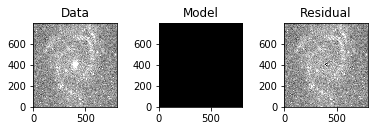

In [20]:
fig = plt.figure()
fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(131)
ax1.imshow(cutout.data, cmap='gray', origin='lower', vmin=9, vmax=11)
ax1.set_title('Data')
ax2 = fig.add_subplot(132)
ax2.imshow(model_image, cmap='gray', origin='lower', vmin=9, vmax=11)
ax2.set_title('Model')
ax3 = fig.add_subplot(133)
ax3.imshow(residual, cmap='gray', origin='lower', vmin=9, vmax=11)
ax3.set_title('Residual')

In [46]:
cutout.data

array([[17.904314, 17.424109, 18.218927, ..., 18.189936, 18.335066,
        18.620531],
       [17.850145, 17.619802, 17.049988, ..., 17.756903, 18.21741 ,
        18.012661],
       [17.20751 , 17.836355, 17.48718 , ..., 17.959875, 18.000162,
        17.559998],
       ...,
       [17.149042, 17.587244, 18.512695, ..., 17.99305 , 17.779224,
        17.799555],
       [17.98196 , 17.311922, 17.928762, ..., 17.742193, 17.14814 ,
        17.816133],
       [17.03715 , 17.69611 , 17.228767, ..., 17.67713 , 17.598856,
        17.872488]], dtype=float32)